In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  8%|█████                                                         | 4062/50000 [00:00<00:01, 40616.65it/s]

 17%|██████████▍                                                   | 8425/50000 [00:00<00:00, 42385.84it/s]

 26%|███████████████▋                                             | 12875/50000 [00:00<00:00, 43347.35it/s]

 35%|█████████████████████▏                                       | 17354/50000 [00:00<00:00, 43915.41it/s]

 44%|██████████████████████████▌                                  | 21823/50000 [00:00<00:00, 44192.60it/s]

 53%|████████████████████████████████                             | 26287/50000 [00:00<00:00, 44342.20it/s]

 62%|█████████████████████████████████████▌                       | 30783/50000 [00:00<00:00, 44542.61it/s]

 70%|██████████████████████████████████████████▉                  | 35238/50000 [00:00<00:00, 44395.11it/s]

 79%|████████████████████████████████████████████████▍            | 39724/50000 [00:00<00:00, 44537.99it/s]

 88%|█████████████████████████████████████████████████████▉       | 44224/50000 [00:01<00:00, 44677.44it/s]

 97%|███████████████████████████████████████████████████████████▍ | 48692/50000 [00:01<00:00, 44604.54it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44089.26it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 41%|█████████████████████████▎                                    | 4074/10000 [00:00<00:00, 40735.09it/s]

 82%|██████████████████████████████████████████████████▌           | 8153/10000 [00:00<00:00, 40762.84it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41343.27it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 blu3najq


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-blu3najq:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/313 [00:00<02:39,  1.96it/s]

  5%|███▎                                                                 | 15/313 [00:00<00:09, 32.09it/s]

  9%|██████▍                                                              | 29/313 [00:00<00:04, 56.86it/s]

 14%|█████████▍                                                           | 43/313 [00:00<00:03, 76.61it/s]

 18%|████████████▌                                                        | 57/313 [00:00<00:02, 91.83it/s]

 23%|███████████████▍                                                    | 71/313 [00:01<00:02, 103.24it/s]

 27%|██████████████████▋                                                 | 86/313 [00:01<00:01, 114.52it/s]

 32%|█████████████████████▌                                             | 101/313 [00:01<00:01, 122.33it/s]

 37%|████████████████████████▌                                          | 115/313 [00:01<00:01, 126.33it/s]

 41%|███████████████████████████▌                                       | 129/313 [00:01<00:01, 129.19it/s]

 46%|██████████████████████████████▌                                    | 143/313 [00:01<00:01, 131.41it/s]

 50%|█████████████████████████████████▌                                 | 157/313 [00:01<00:01, 132.97it/s]

 55%|████████████████████████████████████▌                              | 171/313 [00:01<00:01, 134.04it/s]

 59%|███████████████████████████████████████▌                           | 185/313 [00:01<00:00, 134.82it/s]

 64%|██████████████████████████████████████████▌                        | 199/313 [00:01<00:00, 135.33it/s]

 68%|█████████████████████████████████████████████▌                     | 213/313 [00:02<00:00, 135.01it/s]

 73%|████████████████████████████████████████████████▌                  | 227/313 [00:02<00:00, 135.40it/s]

 77%|███████████████████████████████████████████████████▌               | 241/313 [00:02<00:00, 135.65it/s]

 81%|██████████████████████████████████████████████████████▌            | 255/313 [00:02<00:00, 135.75it/s]

 86%|█████████████████████████████████████████████████████████▌         | 269/313 [00:02<00:00, 136.05it/s]

 90%|████████████████████████████████████████████████████████████▌      | 283/313 [00:02<00:00, 136.16it/s]

 95%|███████████████████████████████████████████████████████████████▌   | 297/313 [00:02<00:00, 136.31it/s]

 99%|██████████████████████████████████████████████████████████████████▌| 311/313 [00:02<00:00, 136.97it/s]

100%|███████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 109.59it/s]

train - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  8%|█████▍                                                                 | 6/79 [00:00<00:01, 58.30it/s]

 25%|█████████████████▍                                                   | 20/79 [00:00<00:00, 103.44it/s]

 43%|█████████████████████████████▋                                       | 34/79 [00:00<00:00, 118.39it/s]

 61%|█████████████████████████████████████████▉                           | 48/79 [00:00<00:00, 125.55it/s]

 78%|██████████████████████████████████████████████████████▏              | 62/79 [00:00<00:00, 129.38it/s]

 96%|██████████████████████████████████████████████████████████████████▍  | 76/79 [00:00<00:00, 131.90it/s]

100%|█████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.45it/s]

val - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  6%|████▍                                                                  | 5/79 [00:00<00:01, 49.69it/s]

 24%|████████████████▌                                                    | 19/79 [00:00<00:00, 100.09it/s]

 42%|████████████████████████████▊                                        | 33/79 [00:00<00:00, 116.09it/s]

 59%|█████████████████████████████████████████                            | 47/79 [00:00<00:00, 123.78it/s]

 77%|█████████████████████████████████████████████████████▎               | 61/79 [00:00<00:00, 127.86it/s]

 95%|█████████████████████████████████████████████████████████████████▌   | 75/79 [00:00<00:00, 131.06it/s]

100%|█████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.73it/s]

test InD - OK


  0%|                                                                              | 0/469 [00:00<?, ?it/s]

  1%|▋                                                                     | 5/469 [00:00<00:09, 48.45it/s]

  4%|██▊                                                                  | 19/469 [00:00<00:04, 99.03it/s]

  7%|████▊                                                               | 33/469 [00:00<00:03, 115.28it/s]

 10%|██████▊                                                             | 47/469 [00:00<00:03, 122.97it/s]

 13%|████████▊                                                           | 61/469 [00:00<00:03, 127.34it/s]

 16%|██████████▊                                                         | 75/469 [00:00<00:03, 129.73it/s]

 19%|████████████▉                                                       | 89/469 [00:00<00:02, 131.57it/s]

 22%|██████████████▋                                                    | 103/469 [00:00<00:02, 132.63it/s]

 25%|████████████████▋                                                  | 117/469 [00:00<00:02, 133.32it/s]

 28%|██████████████████▋                                                | 131/469 [00:01<00:02, 133.97it/s]

 31%|████████████████████▋                                              | 145/469 [00:01<00:02, 134.37it/s]

 34%|██████████████████████▋                                            | 159/469 [00:01<00:02, 133.05it/s]

 37%|████████████████████████▋                                          | 173/469 [00:01<00:02, 133.57it/s]

 40%|██████████████████████████▋                                        | 187/469 [00:01<00:02, 134.02it/s]

 43%|████████████████████████████▋                                      | 201/469 [00:01<00:01, 134.28it/s]

 46%|██████████████████████████████▋                                    | 215/469 [00:01<00:01, 134.56it/s]

 49%|████████████████████████████████▋                                  | 229/469 [00:01<00:01, 134.54it/s]

 52%|██████████████████████████████████▋                                | 243/469 [00:01<00:01, 134.74it/s]

 55%|████████████████████████████████████▋                              | 257/469 [00:01<00:01, 134.92it/s]

 58%|██████████████████████████████████████▋                            | 271/469 [00:02<00:01, 134.96it/s]

 61%|████████████████████████████████████████▋                          | 285/469 [00:02<00:01, 134.88it/s]

 64%|██████████████████████████████████████████▋                        | 299/469 [00:02<00:01, 134.88it/s]

 67%|████████████████████████████████████████████▋                      | 313/469 [00:02<00:01, 134.93it/s]

 70%|██████████████████████████████████████████████▋                    | 327/469 [00:02<00:01, 134.96it/s]

 73%|████████████████████████████████████████████████▋                  | 341/469 [00:02<00:00, 135.02it/s]

 76%|██████████████████████████████████████████████████▋                | 355/469 [00:02<00:00, 134.83it/s]

 79%|████████████████████████████████████████████████████▋              | 369/469 [00:02<00:00, 134.95it/s]

 82%|██████████████████████████████████████████████████████▋            | 383/469 [00:02<00:00, 135.07it/s]

 85%|████████████████████████████████████████████████████████▋          | 397/469 [00:03<00:00, 135.16it/s]

 88%|██████████████████████████████████████████████████████████▋        | 411/469 [00:03<00:00, 135.15it/s]

 91%|████████████████████████████████████████████████████████████▋      | 425/469 [00:03<00:00, 135.08it/s]

 94%|██████████████████████████████████████████████████████████████▋    | 439/469 [00:03<00:00, 135.12it/s]

 97%|████████████████████████████████████████████████████████████████▋  | 453/469 [00:03<00:00, 135.00it/s]

100%|██████████████████████████████████████████████████████████████████▋| 467/469 [00:03<00:00, 136.03it/s]

100%|███████████████████████████████████████████████████████████████████| 469/469 [00:03<00:00, 130.15it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 15%|██████████▏                                                         | 15/100 [00:00<00:00, 140.61it/s]

 30%|████████████████████▍                                               | 30/100 [00:00<00:00, 140.65it/s]

 45%|██████████████████████████████▌                                     | 45/100 [00:00<00:00, 140.92it/s]

 60%|████████████████████████████████████████▊                           | 60/100 [00:00<00:00, 141.09it/s]

 75%|███████████████████████████████████████████████████                 | 75/100 [00:00<00:00, 141.15it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [00:00<00:00, 141.23it/s]

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.05it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 2048) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 2048) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


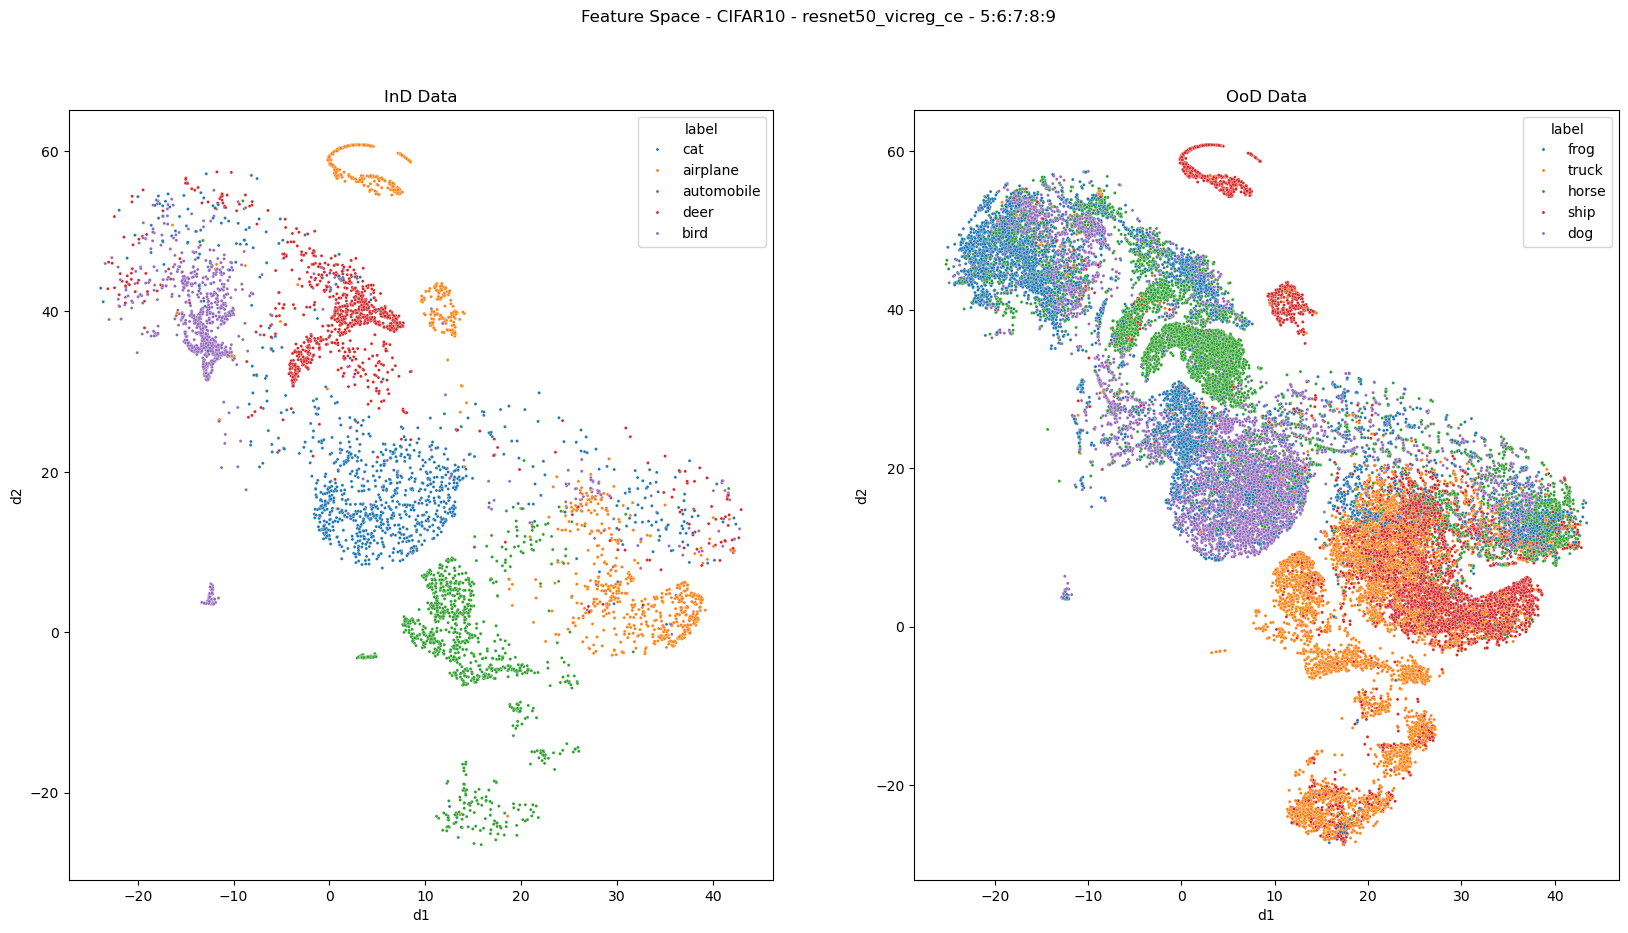

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

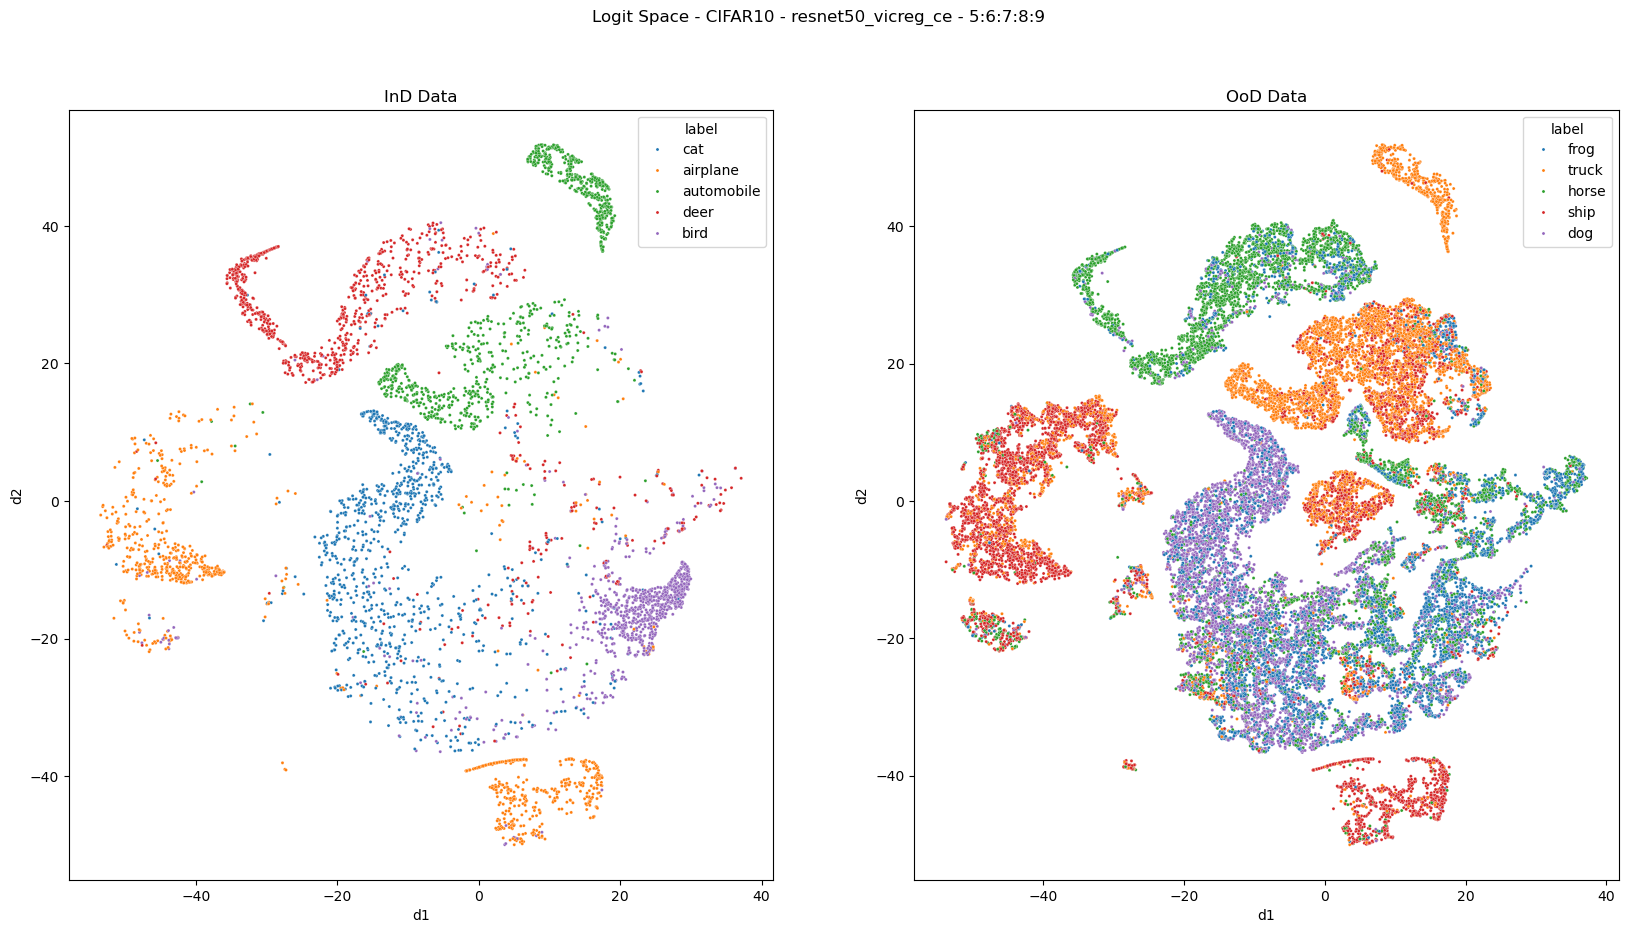

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:04<00:14,  4.89s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:09<00:09,  4.81s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:14<00:04,  4.82s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.89s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.87s/it]

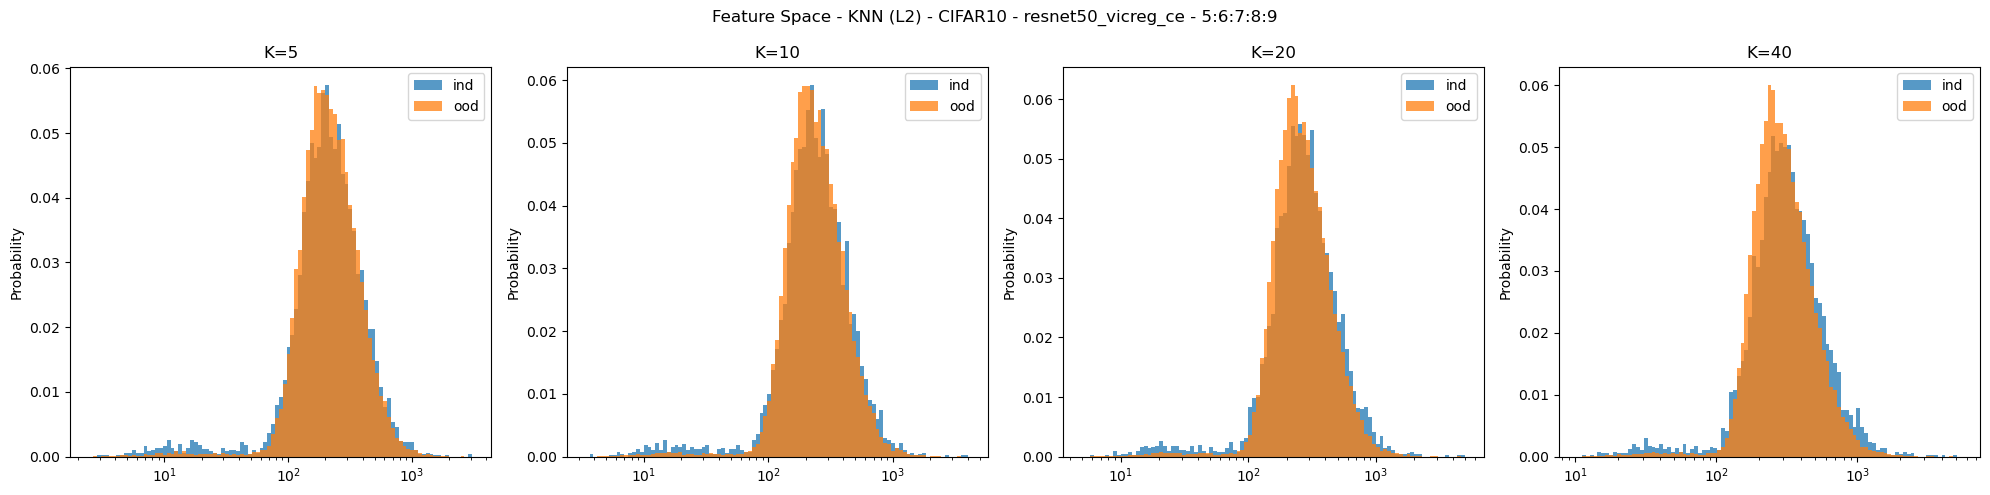

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:04<00:13,  4.66s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:09<00:09,  4.69s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:14<00:04,  4.83s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.87s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.82s/it]

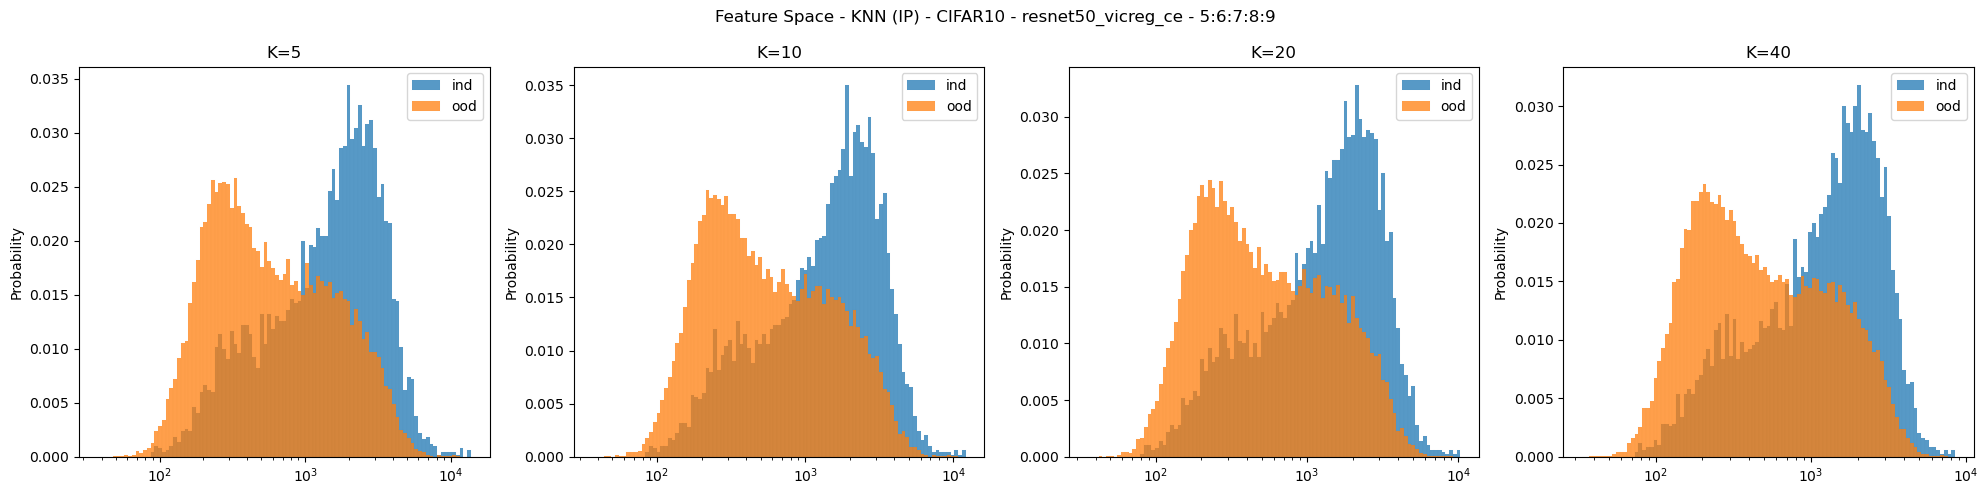

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.13it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.98it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.65it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]

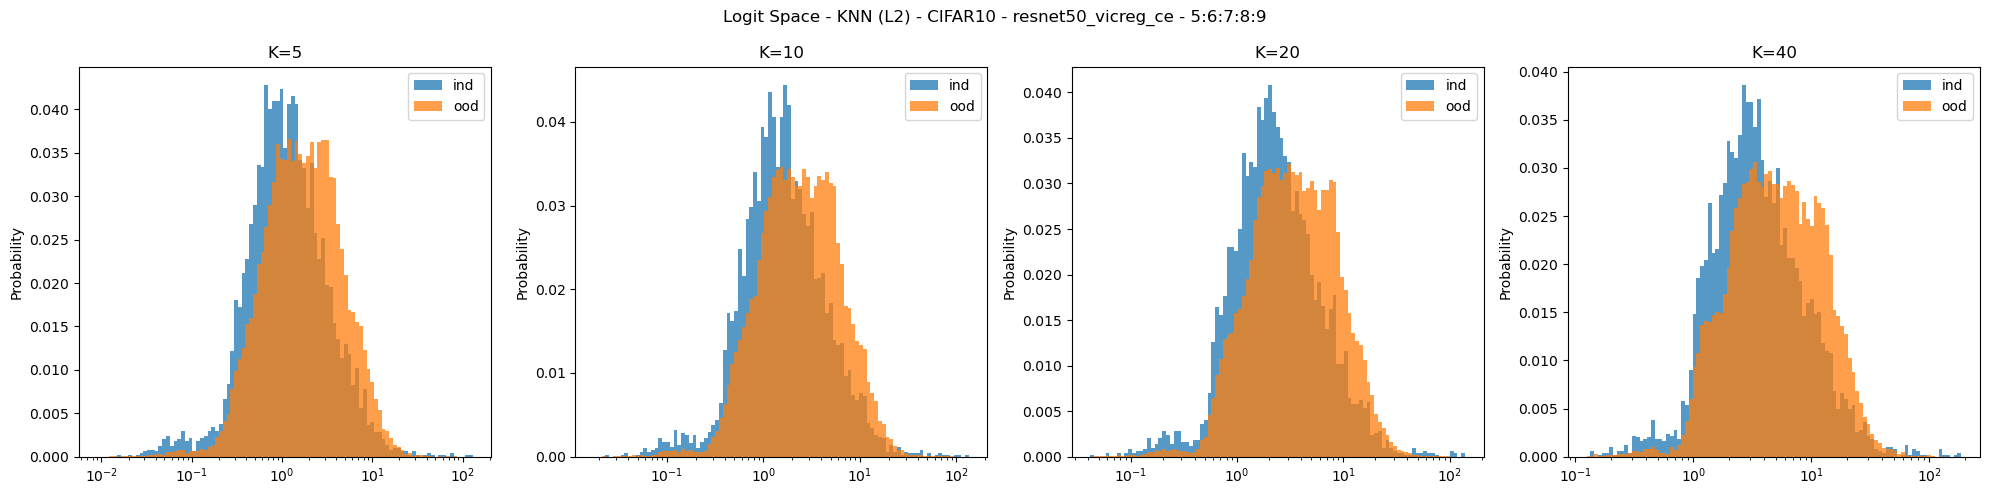

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.94it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.48it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.50it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]

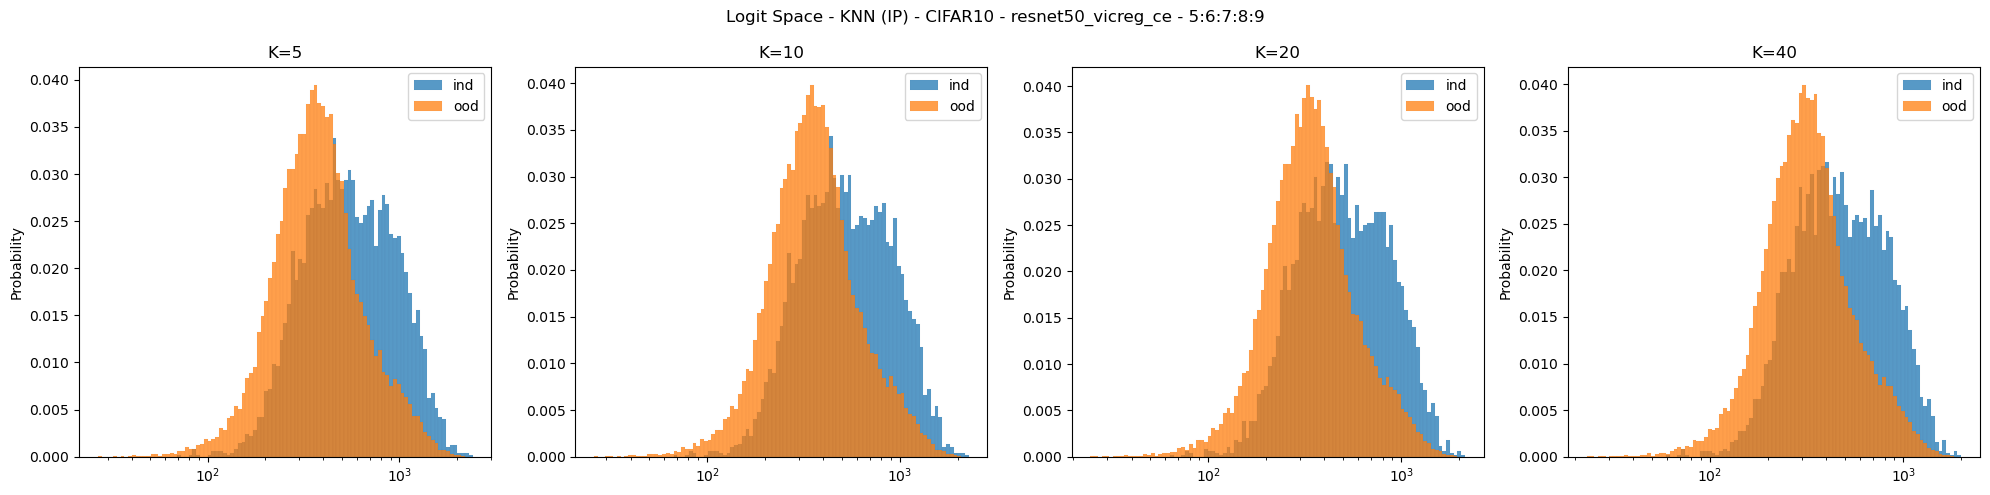

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

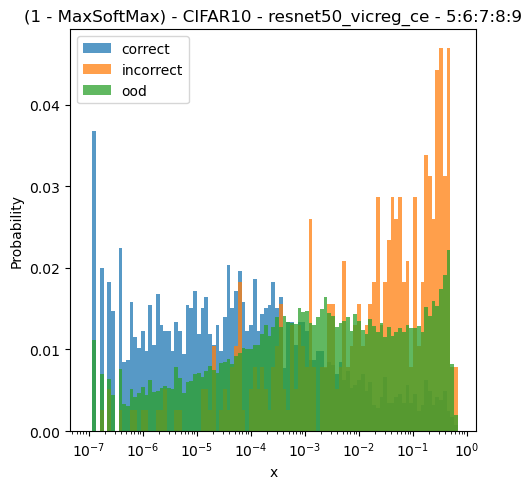

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()